In [1]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install albumentations --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!python -m pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install torchvision --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-l6gamb9i
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-l6gamb9i
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done


In [178]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 3s (3,256 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122531 files and di

In [6]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [42]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
## 함수
datagen=ImageDataGenerator(
    zoom_range = 0.3,     
    width_shift_range=0.2, 
    height_shift_range=0.2
)

def auG(f_path, image_list, i, sub):
    for f in image_list:
            img_path = os.path.join(f_path, i, f)
            image = np.expand_dims(plt.imread(img_path), 0)
            c=0     
            for _ in datagen.flow(image,
                                    batch_size=1,
                                    save_to_dir=os.path.join(f_path,i),
                                    save_prefix=i,
                                    save_format='png'):
                c+=1
                if c > augment_number-(sub):
                    break

## 전역
f_path = '/content/gdrive/My Drive/open/Codes/basic/train'
f_list = os.listdir(f_path)
#f_list.remove('.DS_Store')


## 메인
for i in f_list:
    image_list=os.listdir(os.path.join(f_path,i)) 
    augment_number=10
    
    if len(image_list) > 600:
        continue
    elif 500 < len(image_list) < 600:
        auG(f_path,image_list, i, 7)
    elif 300 < len(image_list) < 400:
        auG(f_path,image_list, i, 5)
    elif 200 < len(image_list) < 300:
        auG(f_path,image_list, i, 2)
    elif 98 < len(image_list) < 200:
        auG(f_path,image_list, i, 0)
    elif 50 < len(image_list) < 60:
        auG(f_path,image_list, i, -20)
    elif 20 < len(image_list) < 30:
        auG(f_path,image_list, i, -70)
    elif 10< len(image_list) < 20:
        auG(f_path,image_list, i, -90)
    elif len(image_list) < 10:
        auG(f_path,image_list, i, -440)

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [46]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [47]:
device

device(type='cuda')

In [48]:
## Hyperparameter Setting

CFG = {
    'IMG_SIZE':224,
    'EPOCHS': 10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':128,
    'SEED': 41
}

In [49]:
from google.colab import drive
drive.mount('/content/gdrive')
# 기본 경로

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
# get dataset

all_img_list = glob.glob('/content/gdrive/My Drive/open/Codes/basic/train/*/*')
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[8])

In [51]:
df

,img_path,label
0,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
1,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
2,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
3,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
4,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
...,...,...
31452,/content/gdrive/My Drive/open/Codes/basic/trai...,울음
31453,/content/gdrive/My Drive/open/Codes/basic/trai...,울음
31454,/content/gdrive/My Drive/open/Codes/basic/trai...,울음
31455,/content/gdrive/My Drive/open/Codes/basic/trai...,울음


In [55]:
df['img_path'][100]

'/content/gdrive/My Drive/open/Codes/basic/train/가구수정/가구수정_0_4118.png'

In [56]:
for filepath in all_img_list:
    print(filepath)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_8944.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_3400.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_6027.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_3696.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_578.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_4122.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_2849.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_7733.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_4715.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_6112.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_2242.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_6275.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_2043.png
/content/gdrive/My Drive/open/Codes/basic/

In [57]:
# split train val dataset
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, stratify=df['label'], random_state=CFG['SEED'])

In [59]:
## Label-Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

In [60]:
## CustomDataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [61]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.RandomBrightnessContrast(p=0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [62]:
#weighted sampling
a_list = train['label'].value_counts()
class_counts = train['label'].value_counts().to_list()
class_weights = [1 / a_list[i] for i in range(len(class_counts))]
num_samples = sum(class_counts)
labels_lists = train['label'].to_list()
weights = [class_weights[labels_lists[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), replacement=True)

In [63]:
# make dataloader
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], sampler=sampler, shuffle=False, num_workers=2)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [64]:
## Model Define

class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True) #densenet161(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha]*19)
        self.alpha[18] = 1-alpha
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [66]:
## Train

def trains(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
    criterion = FocalLoss(gamma=2, alpha=0.25)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [68]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

In [69]:
#init model
model = BaseModel()

In [70]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])

In [71]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

In [72]:
infer_model = trains(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.09147] Val Loss : [0.02366] Val Weighted F1 Score : [0.94532]


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.01521] Val Loss : [0.01182] Val Weighted F1 Score : [0.97175]


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.00843] Val Loss : [0.01031] Val Weighted F1 Score : [0.97619]


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.00764] Val Loss : [0.01404] Val Weighted F1 Score : [0.97577]


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.00633] Val Loss : [0.00887] Val Weighted F1 Score : [0.97918]


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.00522] Val Loss : [0.00953] Val Weighted F1 Score : [0.98076]


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.00509] Val Loss : [0.01057] Val Weighted F1 Score : [0.97724]


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00442] Val Loss : [0.01036] Val Weighted F1 Score : [0.98160]


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00557] Val Loss : [0.00971] Val Weighted F1 Score : [0.98194]


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00440] Val Loss : [0.01275] Val Weighted F1 Score : [0.98306]


In [73]:
preds = []
true = []
inference_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=2)
with torch.no_grad() :
    for img, label in inference_loader :
        img = img.float().to(device)
        label = label.to(device)
        pred = infer_model(img)
        
        preds.extend(pred.argmax(1).detach().cpu().numpy())
        true.extend(label.detach().cpu().numpy().tolist())

In [74]:
from sklearn.metrics import confusion_matrix

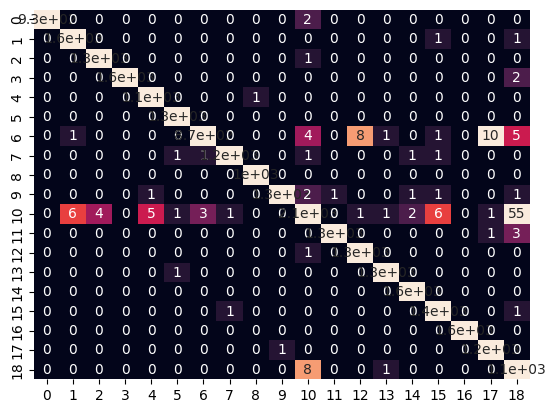

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix(true, preds), annot=True, vmax = 10, vmin=0, cbar=False)
plt.show()

In [80]:
train['pred'] = preds
train['true'] = true

In [81]:
train.head()

,img_path,label,pred,true,err
29108,/content/gdrive/My Drive/open/Codes/basic/trai...,16,16,16,True
7027,/content/gdrive/My Drive/open/Codes/basic/trai...,7,7,7,True
11596,/content/gdrive/My Drive/open/Codes/basic/trai...,6,6,6,True
3077,/content/gdrive/My Drive/open/Codes/basic/trai...,1,1,1,True
13371,/content/gdrive/My Drive/open/Codes/basic/trai...,4,4,4,True


In [82]:
train['err'] = train['pred'] == train['label']

In [83]:
err_ds = train.loc[(train['err'] == False)].copy()

In [87]:
img_err = err_ds['img_path'].values

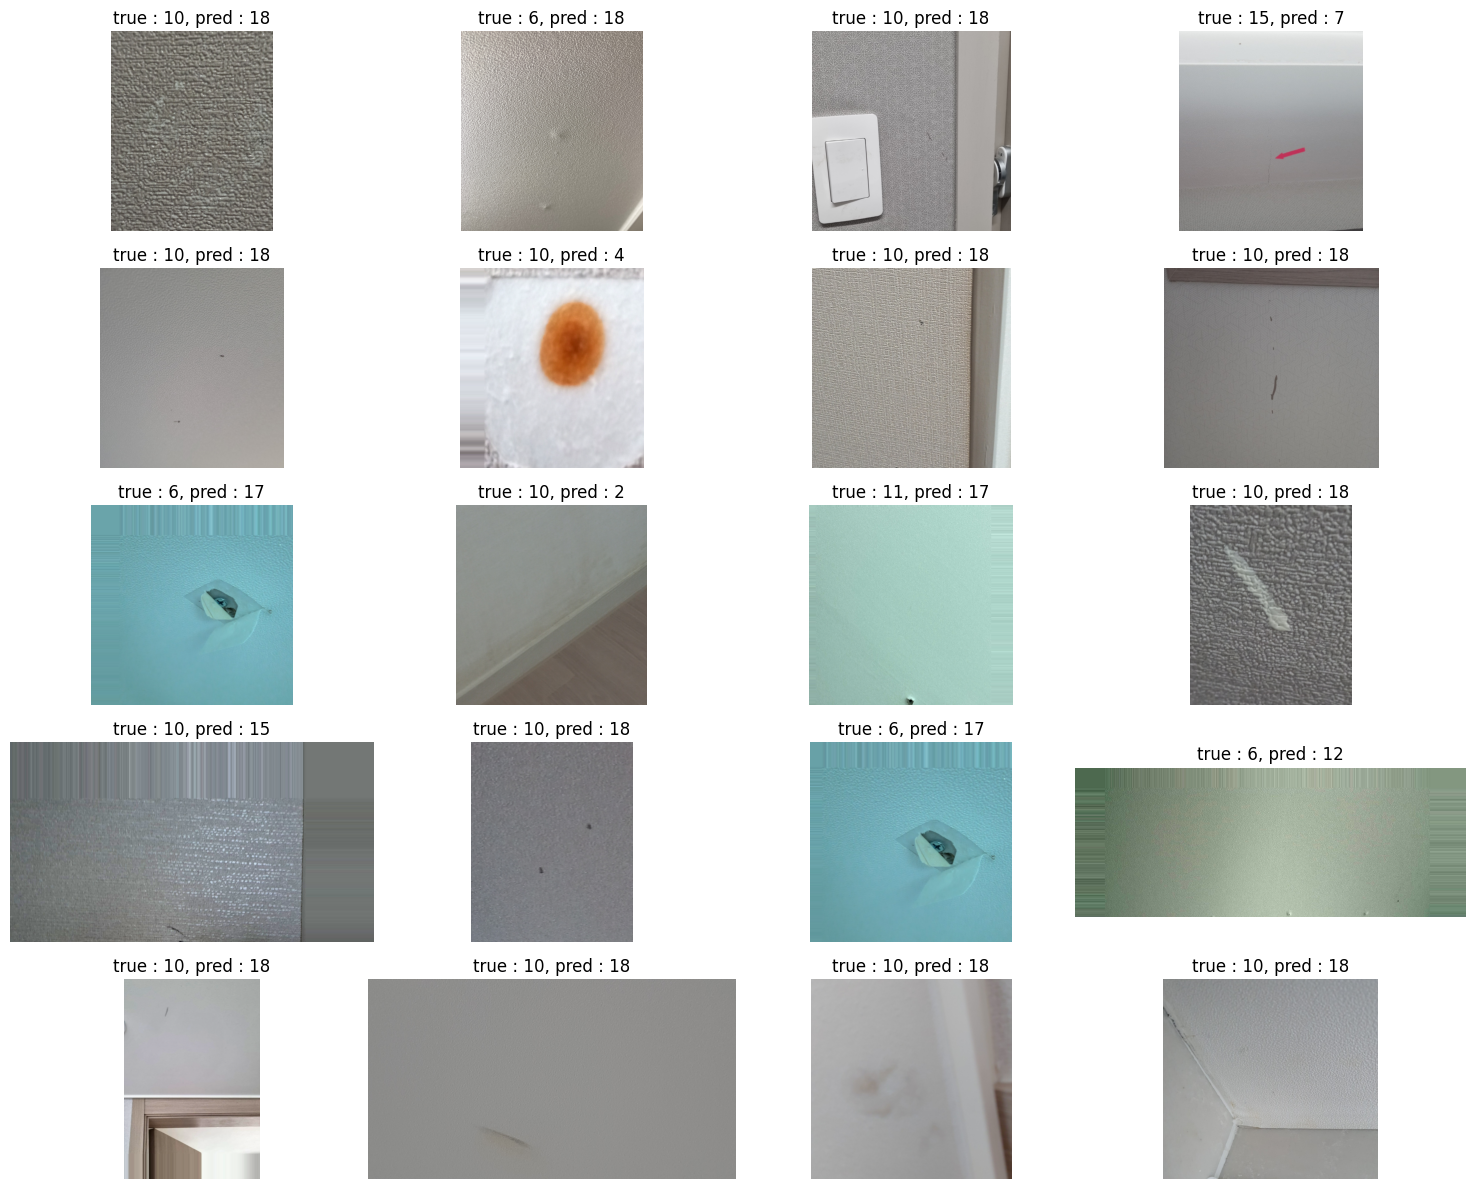

In [88]:
plt.figure(figsize=(15,12))
for i in range(20):
    plt.subplot(5,4,i+1)
    im = Image.open(err_ds['img_path'].values[i])
    plt.imshow(im)
    plt.axis('off')
    tr = err_ds['label'].values[i]
    pr = err_ds['pred'].values[i]
    plt.title(f'true : {tr}, pred : {pr}')
plt.tight_layout()
plt.show()

In [96]:
#test
test = pd.read_csv('/content/gdrive/My Drive/open/Codes/basic/test.csv')

In [99]:
test

,id,img_path
0,TEST_000,./test/000.png
1,TEST_001,./test/001.png
2,TEST_002,./test/002.png
3,TEST_003,./test/003.png
4,TEST_004,./test/004.png
...,...,...
787,TEST_787,./test/787.png
788,TEST_788,./test/788.png
789,TEST_789,./test/789.png
790,TEST_790,./test/790.png


In [100]:
test["img_path_real"] = test["img_path"].str.replace(".","/content/gdrive/My Drive/open/Codes/basic", 1)

In [101]:
test

,id,img_path,img_path_real
0,TEST_000,./test/000.png,/content/gdrive/My Drive/open/Codes/basic/test...
1,TEST_001,./test/001.png,/content/gdrive/My Drive/open/Codes/basic/test...
2,TEST_002,./test/002.png,/content/gdrive/My Drive/open/Codes/basic/test...
3,TEST_003,./test/003.png,/content/gdrive/My Drive/open/Codes/basic/test...
4,TEST_004,./test/004.png,/content/gdrive/My Drive/open/Codes/basic/test...
...,...,...,...
787,TEST_787,./test/787.png,/content/gdrive/My Drive/open/Codes/basic/test...
788,TEST_788,./test/788.png,/content/gdrive/My Drive/open/Codes/basic/test...
789,TEST_789,./test/789.png,/content/gdrive/My Drive/open/Codes/basic/test...
790,TEST_790,./test/790.png,/content/gdrive/My Drive/open/Codes/basic/test...


In [102]:
test_dataset = CustomDataset(test['img_path_real'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [104]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(test_loader):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [105]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/7 [00:00<?, ?it/s]

In [200]:
#submission
submit = pd.read_csv('/content/gdrive/My Drive/open/Codes/basic/sample_submission.csv')

In [191]:
submit

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손
...,...,...
787,TEST_787,훼손
788,TEST_788,훼손
789,TEST_789,훼손
790,TEST_790,훼손


In [201]:
submit['label'] = preds

In [203]:
submit.head()

,id,label
0,TEST_000,18
1,TEST_001,10
2,TEST_002,18
3,TEST_003,7
4,TEST_004,18


In [195]:
folder_list = os.listdir('/content/gdrive/My Drive/open/Codes/basic/train')
folder_list.sort()
folder_list

['가구수정',
 '걸레받이수정',
 '곰팡이',
 '꼬임',
 '녹오염',
 '들뜸',
 '면불량',
 '몰딩수정',
 '반점',
 '석고수정',
 '오염',
 '오타공',
 '울음',
 '이음부불량',
 '창틀,문틀수정',
 '터짐',
 '틈새과다',
 '피스',
 '훼손']

In [196]:
import unicodedata
label_data = [unicodedata.normalize('NFC', one_ans_val) for one_ans_val in folder_list]

In [197]:
submit['label'] = submit['label'].map(dict(zip(range(19),label_data)))
submit

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,몰딩수정
4,TEST_004,훼손
...,...,...
787,TEST_787,오염
788,TEST_788,오염
789,TEST_789,오염
790,TEST_790,"창틀,문틀수정"


In [198]:
path ='/content/gdrive/My Drive/open/Codes/basic/submit.csv'
submit.to_csv(path, index=False, encoding = 'utf-8-sig') 

In [199]:
# 모델 save
PATH = 'model.pickle'
torch.save(model.state_dict(), PATH)